# SNN-ANN Model

In [2]:
! pip install snntorch

  Obtaining dependency information for snntorch from https://files.pythonhosted.org/packages/4b/55/95ee9e0e26cf74a464603ef7ab84be186133bfb95ac0c5ae9d1eb408b69b/snntorch-0.7.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for nir from https://files.pythonhosted.org/packages/a8/e1/60b9014266c26d170b2f1bc7fe1b7b6ad823ad8cb302104ca306685311ac/nir-1.0.1-py3-none-any.whl.metadata
  Obtaining dependency information for nirtorch from https://files.pythonhosted.org/packages/cd/74/92cc684fd83636b072318693676877af0d80c4e136067237f147f9a18d6f/nirtorch-1.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 7.9 MB/s eta 0:00:00


In [3]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import utils as utls

import snntorch as snn
from snntorch import utils
from snntorch import surrogate

import numpy as np
import torch.optim as optim
import time

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Preprocess the data
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# Define a simple ANN model
class SimpleANN(tf.keras.Model):
    def __init__(self):
        super(SimpleANN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(512, activation='relu')
        self.dense2 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, inputs):
        x = self.dense1(inputs)
        return self.dense2(x)

# Define a hypothetical SNN model (this is conceptual)
class SimpleSNN:
    def process(self, inputs):
        # Process inputs through SNN layers (hypothetical)
        # In reality, this would involve a lot more complexity
        return inputs  # For now, just returning the inputs

# Combine SNN and ANN in a hybrid model
class HybridSNN_ANN(tf.keras.Model):
    def __init__(self):
        super(HybridSNN_ANN, self).__init__()
        self.snn = SimpleSNN()
        self.ann = SimpleANN()

    def call(self, inputs):
        snn_output = self.snn.process(inputs)
        return self.ann(snn_output)

# Instantiate and compile the model
model = HybridSNN_ANN()
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, epochs=5, batch_size=128)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)


In [4]:
class HybridSNNANN(nn.Module):
    def __init__(self, beta, thresh, latent_dim, num_steps):
        super(HybridSNNANN, self).__init__()
        self.num_steps = num_steps

        # SNN Encoder
        self.snn_encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1, stride=2),
            nn.BatchNorm2d(32),
            snn.Leaky(beta=beta, threshold=thresh, init_hidden=True),
            nn.Conv2d(32, 64, 3, padding=1, stride=2),
            nn.BatchNorm2d(64),
            snn.Leaky(beta=beta, threshold=thresh, init_hidden=True),
            nn.Conv2d(64, 128, 3, padding=1, stride=2),
            nn.BatchNorm2d(128),
            snn.Leaky(beta=beta, threshold=thresh, init_hidden=True),
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, latent_dim),
            snn.Leaky(beta=beta, threshold=thresh, init_hidden=True, output=True)
        )

        # ANN Decoder
        self.ann_decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, 3, padding=1, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, padding=1, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, padding=1, stride=2, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
            # Reset states
            utils.reset(self.snn_encoder)
            utils.reset(self.ann_decoder)

            # Encode
            spk_rec = []
            mem_rec = []
            spike_data = []  # To store spike data

            for step in range(self.num_steps):
                spk_x, mem_x = self.snn_encoder(x) # spikes, membrane potential
                spk_rec.append(spk_x)
                mem_rec.append(mem_x)
                spike_data.append(spk_x.detach().cpu().numpy())  # Store spike data
            spk_rec = torch.stack(spk_rec, dim=2)
            mem_rec = torch.stack(mem_rec, dim=2) 
                # combines a list of tensors representing membrane potentials at different time steps into a single tensor. 
                #It adds a new dimension at the third position (dim=2), effectively creating a 3D tensor 

            # Decode
            decoded_x = []
            for step in range(self.num_steps):
                x_recon = self.ann_decoder(mem_rec[..., step]) #  2D slices of the 3D data at each iteration of the loop
                decoded_x.append(x_recon)
            decoded_x = torch.stack(decoded_x, dim=4)

            out = decoded_x[:,:,:,:,-1]  # Taking the output at the last time step
            return out, spike_data  # Return the output and spike data

In [5]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    total_loss = 0.0

    for batch_idx, (data, _) in enumerate(train_loader):  # Ignore original labels
        data = data.to(device)
        optimizer.zero_grad()
        output, train_spike_data = model(data)
        loss = criterion(output, data)  # Compare output with the input image
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    return average_loss, train_spike_data

# Validation function
def validate(model, device, val_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():  # Disable gradient calculation
        for batch_idx, (data, _) in enumerate(val_loader):
            data = data.to(device)
            output, val_spike_data = model(data)
            loss = criterion(output, data)
            val_loss += loss.item()

    average_val_loss = val_loss / len(val_loader)
    return average_val_loss, val_spike_data



In [6]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# MNIST Dataset transformation
from torch.utils.data import random_split

batch_size = 250
input_size = 32 #size of input to first convolutional layer

# Load MNIST
train_dataset = datasets.MNIST(root='dataset/', train=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Resize((input_size, input_size)),transforms.Normalize((0,), (1,))]), download=True)

# Parameters
validation_split = 0.2  # let's say you want to use 20% of the data for validation
num_train = len(train_dataset)
num_val = int(num_train * validation_split)
num_train = num_train - num_val

# Split the dataset
train_dataset, val_dataset = random_split(train_dataset, [num_train, num_val])

# Create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) 

test_dataset = datasets.MNIST(root='dataset/', train=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Resize((input_size, input_size)),transforms.Normalize((0,), (1,))]), download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


# Parameters and Run training and testing

# Initialize the model
beta = 0.5
thresh = 1.0
latent_dim = 256
num_steps = 10
model = HybridSNNANN(beta, thresh, latent_dim, num_steps)



#setup GPU
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = model.to(device)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()  # Assuming MSE loss, adjust as per your requirement


100%|██████████| 9912422/9912422 [00:00<00:00, 145319824.83it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 46770538.16it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 43596526.57it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8197301.54it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


<class 'torch.Tensor'>
torch.Size([250, 1, 32, 32])
torch.Size([250])
(32, 32)


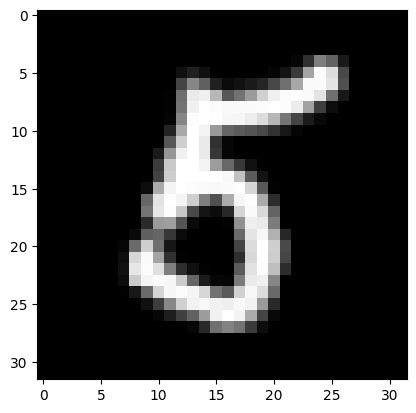

In [7]:
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)
#Printing the size of one image
print(images[1].numpy().squeeze().shape)

plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

In [8]:
# Training loop    
train_losses = []
train_spikes = []
val_losses = []
val_spikes = []

num_epochs = 50
# Early Stopping parameters
patience = 5
best_val_loss = float('inf')
patience_counter = 0

start_time = time.time()  # Record the start time of the training

for epoch in range(num_epochs):
    epoch_start_time = time.time()  # Start time of the epoch

    train_loss, train_spike_data = train(model, device, train_loader, optimizer, criterion, epoch)
    train_losses.append(train_loss)
    train_spikes.append(train_spike_data)
    # Training loop with early stopping
    # Validation phase
    val_loss, val_spike_data = validate(model, device, val_loader, criterion)
    val_losses.append(val_loss)
    val_spikes.append(val_spike_data)
    
    print(f'Epoch {epoch},Training Loss: {train_loss:.4f},Validation Loss: {val_loss:.4f}')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print("Early stopping triggered")
        break
    

end_time = time.time()  # Record the end time of the training
print(f"Training completed in {end_time - start_time:.2f} seconds.")


Epoch 0,Training Loss: 0.0389,Validation Loss: 0.0129
Epoch 1,Training Loss: 0.0081,Validation Loss: 0.0065
Epoch 2,Training Loss: 0.0049,Validation Loss: 0.0046
Epoch 3,Training Loss: 0.0039,Validation Loss: 0.0038
Epoch 4,Training Loss: 0.0032,Validation Loss: 0.0033
Epoch 5,Training Loss: 0.0029,Validation Loss: 0.0028
Epoch 6,Training Loss: 0.0026,Validation Loss: 0.0030
Epoch 7,Training Loss: 0.0025,Validation Loss: 0.0025
Epoch 8,Training Loss: 0.0023,Validation Loss: 0.0027
Epoch 9,Training Loss: 0.0022,Validation Loss: 0.0029
Epoch 10,Training Loss: 0.0021,Validation Loss: 0.0022
Epoch 11,Training Loss: 0.0020,Validation Loss: 0.0021
Epoch 12,Training Loss: 0.0019,Validation Loss: 0.0022
Epoch 13,Training Loss: 0.0018,Validation Loss: 0.0021
Epoch 14,Training Loss: 0.0018,Validation Loss: 0.0019
Epoch 15,Training Loss: 0.0017,Validation Loss: 0.0018
Epoch 16,Training Loss: 0.0017,Validation Loss: 0.0021
Epoch 17,Training Loss: 0.0016,Validation Loss: 0.0017
Epoch 18,Training Lo

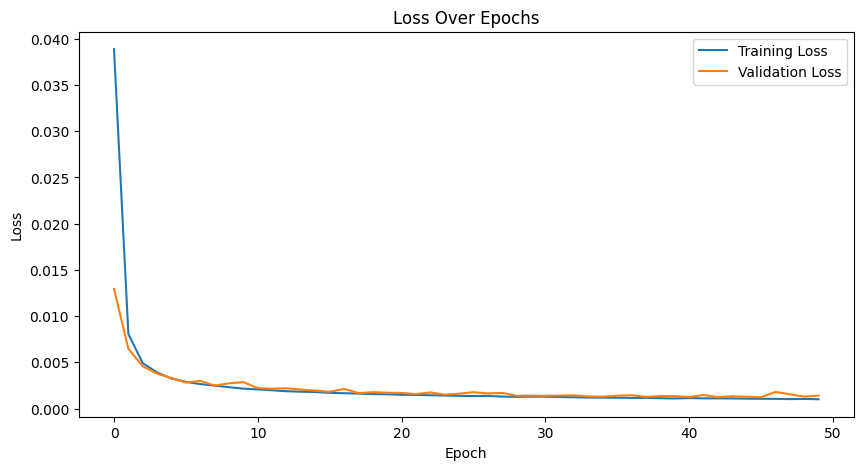

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


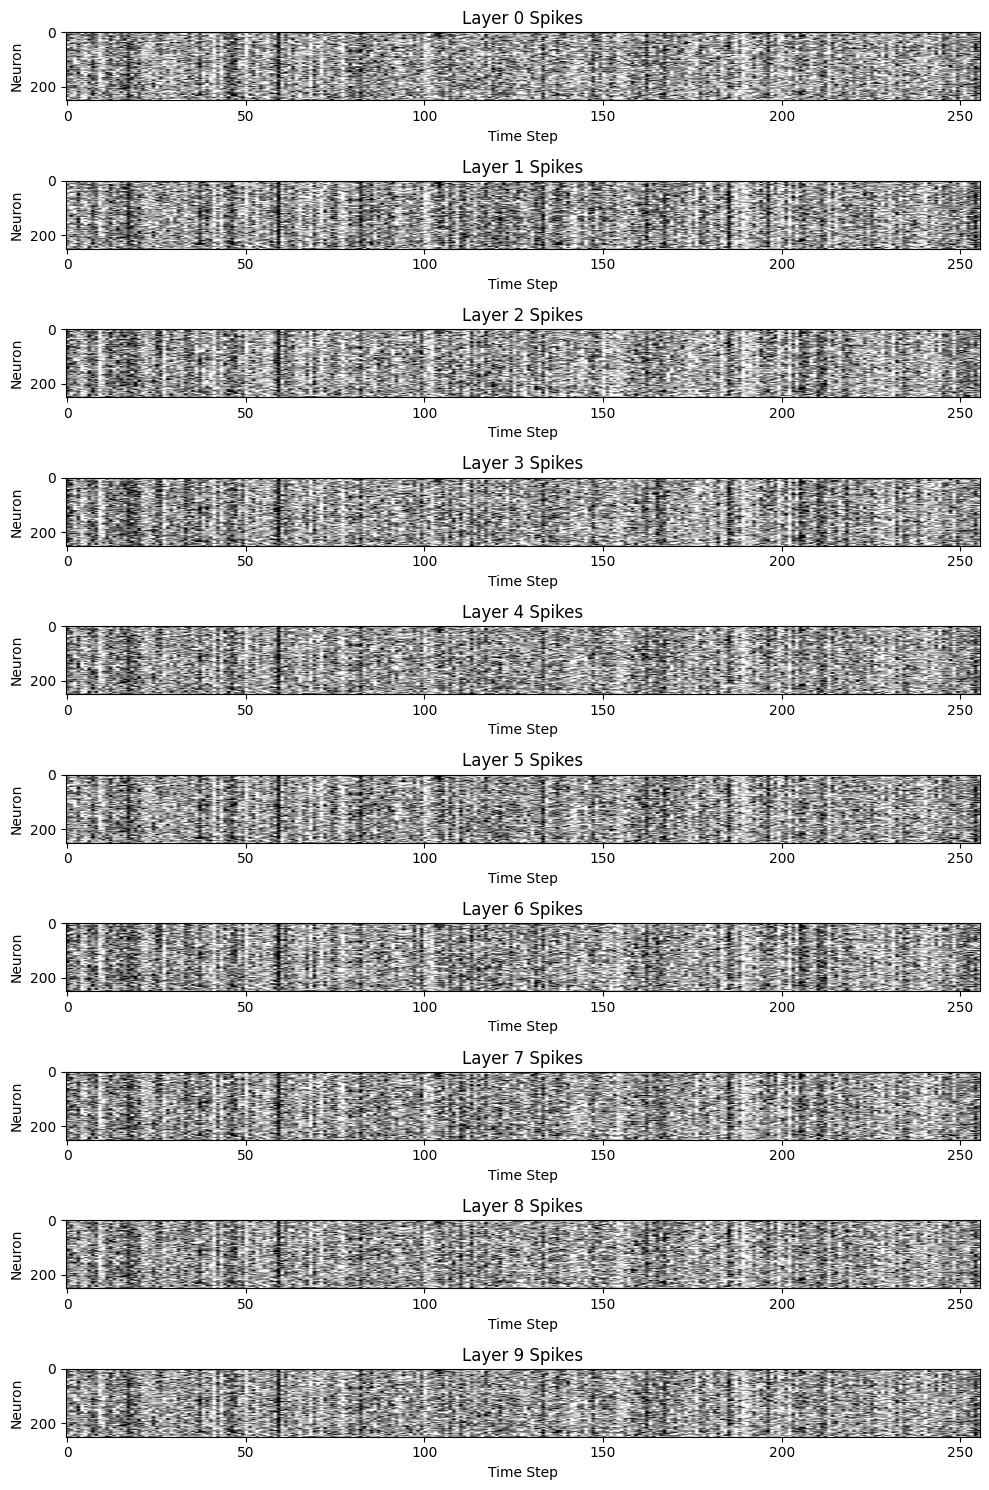

In [17]:
# Spike data visualization
plt.figure(figsize=(10, 15))
for i, spikes in enumerate(val_spike_data):
    plt.subplot(len(val_spike_data), 1, i + 1)
    plt.imshow(spikes, cmap='binary', aspect='auto')
    plt.title(f"Layer {i} Spikes")
    plt.ylabel("Neuron")
    plt.xlabel("Time Step")

plt.tight_layout()
plt.show()

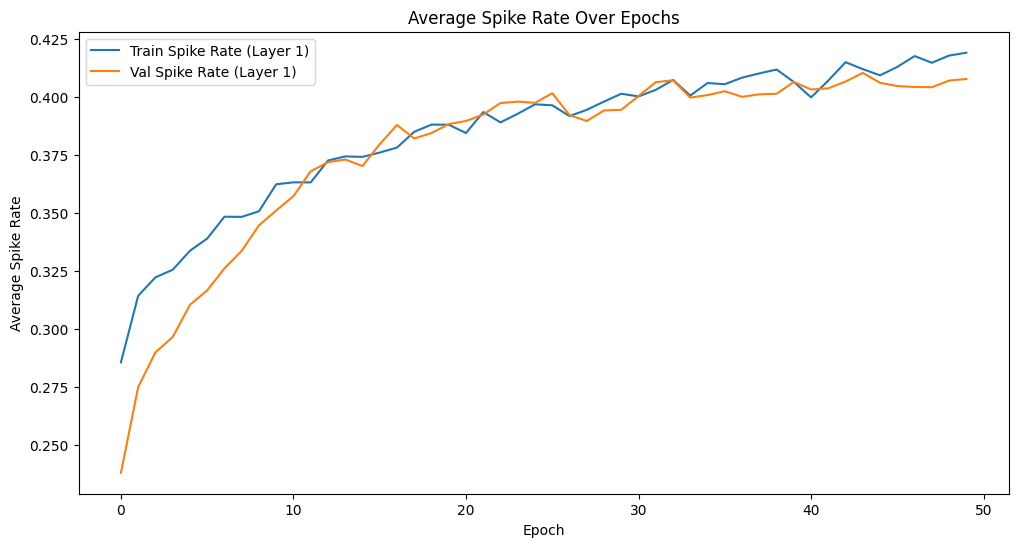

In [19]:
# Calculate average spike rate per epoch for the first layer/neuron
avg_spike_rate_per_epoch = [np.mean(spike_data[0]) for spike_data in train_spikes]
val_spike_rate_per_epoch = [np.mean(spike_data[0]) for spike_data in val_spikes]

# Plot Spike Data
plt.figure(figsize=(12, 6))
plt.plot(avg_spike_rate_per_epoch, label='Train Spike Rate (Layer 1)')
plt.plot(val_spike_rate_per_epoch, label='Val Spike Rate (Layer 1)')
plt.title('Average Spike Rate Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Spike Rate')
plt.legend()
plt.show()

In [11]:
# Calculate the average loss for the entire test set
total_loss = 0

with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        output, test_spikes = model(data)
        loss = criterion(output, data)
        total_loss += loss.item()

avg_loss = total_loss / len(test_loader)
print(f'Test set: Average loss: {avg_loss:.4f}')

Test set: Average loss: 0.0014


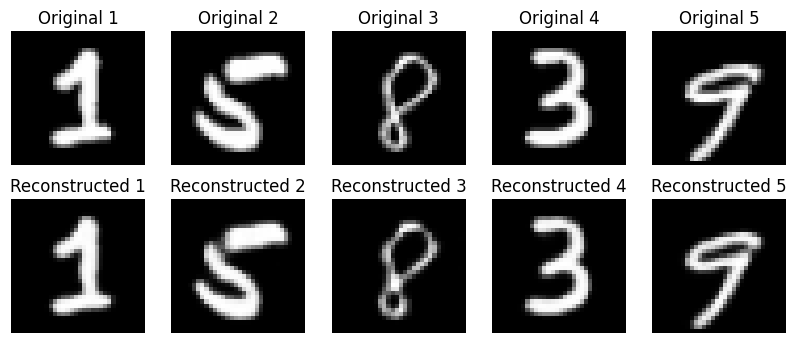

In [14]:
import matplotlib.pyplot as plt
import torch

# Get some test data for visualization
dataiter = iter(test_loader)
images, _ = next(dataiter)
images = images.to(device)

# Get the output from the model for these images
with torch.no_grad():
    model.eval()
    outputs, _ = model(images)

# Convert images and outputs to CPU for plotting if running on GPU
images = images.cpu()
outputs = outputs.cpu()

# Plot the first few images and their reconstructions
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
for i in range(5):
    # Display original images
    ax = axes[0, i]
    ax.imshow(images[i].squeeze(), cmap='Greys_r')
    ax.set_title(f'Original {i+1}')
    ax.axis('off')

    # Display reconstructed images
    ax = axes[1, i]
    ax.imshow(outputs[i].squeeze(), cmap='Greys_r')
    ax.set_title(f'Reconstructed {i+1}')
    ax.axis('off')

plt.show()

# New modifications

In [ ]:
! pip install torchsummary

In [ ]:
from torchsummary import summary

model.to(device)  # Ensure the model is on the correct device
summary(model, input_size=(1, input_size, input_size))  # input_size should match the model's input
